# TES biasing (Ari)

You will find that the names of TES-biasing functions seem arcane and convoluted. This is due to the organic evolution of the software as subtle changes to the functionality became necessary. The overall organization of the software has been stable for some time now, so the names of these functions are likely to change in the near future to be simpler and more self-explanatory.

## Setting up

This notebook assumes that resonators have been tuned, flux ramp is on and tone tracking is on.

Import pysmurf and instantiate a pysmurf object. Specify your configuration file (cfg_file). Since we are working interactively, set make_logfile to False. This will print messages to the terminal rather than just to a log file.

In [1]:
import pysmurf
import numpy as np
cfg_file='/usr/local/controls/Applications/smurf/pysmurf/pysmurf/cfg_files/experiment_fp28_smurfsrv04.cfg'
S = pysmurf.SmurfControl(make_logfile=False,cfg_file=cfg_file)

## Setting bias voltages

Check current state of bias voltages. Currently, in Frankenpolar we are only using bias group 3 for TESs. This function returns an array of bias voltages corresponding to the bias groups.

In [2]:
S.get_tes_bias_bipolar_array()

array([0., 0., 0., 0., 0., 0., 0., 0.])

Turn off bias voltages.

In [3]:
S.set_tes_bias(3,0.)

Manually setting a TES bias on group 3. Then check that the bias voltage has been updated.

In [4]:
S.set_tes_bias_bipolar(3, 1.2)
S.get_tes_bias_bipolar_array()

array([0.        , 0.        , 0.        , 1.19998932, 0.        ,
       0.        , 0.        , 0.        ])

Overbias to the voltage set by overbias_voltage, and then drop to a bias point set by tes_bias. Use group 3 as an example. The overbias voltage is always in high-current mode. The TES bias point can be chosen to be in either high- or low-current mode. For the current system at Stanford. It is more convenient to operate the TESs in low-current mode, which also has better filtering on the bias lines. 

After dropping to a bias point, check again that the bias voltage has been set correctly.

In [5]:
S.overbias_tes(3,overbias_voltage=15.,tes_bias=3.4,high_current_mode=False)
S.get_tes_bias_bipolar_array()

[ 2019-02-03 22:57:48 ]  Old relay 0b1101
[ 2019-02-03 22:57:48 ]  New relay 0b1101
[ 2019-02-03 22:57:48 ]  Driving high current through TES. Waiting 5.0
[ 2019-02-03 22:57:53 ]  Old relay 0b1101
[ 2019-02-03 22:57:53 ]  New relay 0b1001
[ 2019-02-03 22:57:53 ]  Waiting 20.00 seconds to cool
[ 2019-02-03 22:58:13 ]  Done waiting.


array([0.        , 0.        , 0.        , 3.39996338, 0.        ,
       0.        , 0.        , 0.        ])

Now just turn everything off.

In [6]:
S.set_tes_bias(3,0.)

## IV curves

Take IV curves on chosen bias groups. The Stanford system currently only has TESs on group 3, but we can run the code on multiple groups anyway.

Set bias_groups to be the list of groups for which you wish to measure IV curves. Choose whether to run the IV in high- or low-current mode with the boolean high_current_mode. On the Stanford system, it is possible to run in either mode. The IV curve runs from a high voltage down to a low voltage. The default low voltage is 0, but it can be changed with the default argument bias_low. The upper end of the IV curve is controlled by bias_high. The voltage is decreased from bias_high to bias_low in steps of size bias_step. To kick the TESs out of the superconducting state to begin the IV curve, a large voltage is supplied that is set by overbias_voltage. The TESs are then dropped down to bias_high (in either high- or low-current mode depending on the boolean high_current_mode), and we wait for a time specified by the optional argument cool_wait (seconds) before beginning the IV curve.

The IV script automatically analyzes the data and makes plots. Many channels will produce little more than noise, though, since they are either not connected to TESs or not on the active bias groups. To avoid wasting time on the analysis of unresponsive channels, we set a threshold phase excursion, i.e., a minimum amount that the flux-ramp phase, our raw data, has to change by, and don't analyze channels that move by a smaller amount. This threshold is controlled by the parameter phase_excursion_min and is set in radians. If we refer 1 radian of flux-ramp phase shift to a physical TES current, we find that it is approximately equivalent, within an O(1) factor, to 1 uA.

In [7]:
S.slow_iv_all(bias_groups=[3],bias_high=5.,bias_low=0.,bias_step=0.02,high_current_mode=True,overbias_voltage=15.,cool_wait=30.)

[ 2019-02-03 22:58:52 ]  Old relay 0b1001
[ 2019-02-03 22:58:52 ]  New relay 0b1101
[ 2019-02-03 22:58:52 ]  Driving high current through TES. Waiting 2.0
[ 2019-02-03 22:58:54 ]  Waiting 30.00 seconds to cool
[ 2019-02-03 22:59:24 ]  Done waiting.
[ 2019-02-03 22:59:24 ]  Turning lmsGain to 0.
[ 2019-02-03 22:59:24 ]  Starting to take IV.
[ 2019-02-03 22:59:24 ]  Starting TES bias ramp.
[ 2019-02-03 22:59:24 ]  Starting to take IV.
[ 2019-02-03 22:59:24 ]  Starting TES bias ramp.
[ 2019-02-03 22:59:25 ]  Writing PyRogue configuration to file : /data/smurf_data/20190203/1549263430/outputs/1549263565.yml
[ 2019-02-03 22:59:36 ]  Writing to file : /data/smurf_data/20190203/1549263430/outputs/1549263565.dat
[ 2019-02-03 22:59:39 ]  Band 2
[ 2019-02-03 22:59:39 ]  Band 3
[ 2019-02-03 22:59:39 ]  Generating gcp mask file. 397 channels added
[ 2019-02-03 22:59:39 ]  Reading SMuRF to GCP config file
[ 2019-02-03 22:59:39 ]  Reading SMuRF to GCP config file
[ 2019-02-03 22:59:39 ]  caput test_

[ 2019-02-03 23:00:08 ]  Bias at 1.360
[ 2019-02-03 23:00:08 ]  Bias at 1.340
[ 2019-02-03 23:00:08 ]  Bias at 1.320
[ 2019-02-03 23:00:08 ]  Bias at 1.300
[ 2019-02-03 23:00:08 ]  Bias at 1.280
[ 2019-02-03 23:00:08 ]  Bias at 1.260
[ 2019-02-03 23:00:08 ]  Bias at 1.240
[ 2019-02-03 23:00:09 ]  Bias at 1.220
[ 2019-02-03 23:00:09 ]  Bias at 1.200
[ 2019-02-03 23:00:09 ]  Bias at 1.180
[ 2019-02-03 23:00:09 ]  Bias at 1.160
[ 2019-02-03 23:00:09 ]  Bias at 1.140
[ 2019-02-03 23:00:09 ]  Bias at 1.120
[ 2019-02-03 23:00:09 ]  Bias at 1.100
[ 2019-02-03 23:00:10 ]  Bias at 1.080
[ 2019-02-03 23:00:10 ]  Bias at 1.060
[ 2019-02-03 23:00:10 ]  Bias at 1.040
[ 2019-02-03 23:00:10 ]  Bias at 1.020
[ 2019-02-03 23:00:10 ]  Bias at 1.000
[ 2019-02-03 23:00:10 ]  Bias at 0.980
[ 2019-02-03 23:00:10 ]  Bias at 0.960
[ 2019-02-03 23:00:11 ]  Bias at 0.940
[ 2019-02-03 23:00:11 ]  Bias at 0.920
[ 2019-02-03 23:00:11 ]  Bias at 0.900
[ 2019-02-03 23:00:11 ]  Bias at 0.880
[ 2019-02-03 23:00:11 ]  

[ 2019-02-03 23:00:41 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b2_ch064.png
[ 2019-02-03 23:00:43 ]  Analyzing band 2 channel 65
[ 2019-02-03 23:00:43 ]  Skipping channel 65:  phase excursion < min
[ 2019-02-03 23:00:43 ]  Analyzing band 2 channel 66
[ 2019-02-03 23:00:44 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b2_ch066.png
[ 2019-02-03 23:00:46 ]  Analyzing band 2 channel 67
[ 2019-02-03 23:00:46 ]  Skipping channel 67:  phase excursion < min
[ 2019-02-03 23:00:46 ]  Analyzing band 2 channel 70
[ 2019-02-03 23:00:46 ]  Skipping channel 70:  phase excursion < min
[ 2019-02-03 23:00:46 ]  Analyzing band 2 channel 73
[ 2019-02-03 23:00:46 ]  Skipping channel 73:  phase excursion < min
[ 2019-02-03 23:00:46 ]  Analyzing band 2 channel 74
[ 2019-02-03 23:00:46 ]  Skipping channel 74:  phase excursion < min
[ 2019-02-03 23:00:46 ]  Analyzing band 2 channel 76
[ 2019-02-03 23:00:46 ]  Skipping channel 76: 

[ 2019-02-03 23:01:12 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b2_ch213.png
[ 2019-02-03 23:01:14 ]  Analyzing band 2 channel 215
[ 2019-02-03 23:01:14 ]  Skipping channel 215:  phase excursion < min
[ 2019-02-03 23:01:14 ]  Analyzing band 2 channel 217
[ 2019-02-03 23:01:15 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b2_ch217.png
[ 2019-02-03 23:01:17 ]  Analyzing band 2 channel 218
[ 2019-02-03 23:01:17 ]  Skipping channel 218:  phase excursion < min
[ 2019-02-03 23:01:17 ]  Analyzing band 2 channel 219
[ 2019-02-03 23:01:17 ]  Skipping channel 219:  phase excursion < min
[ 2019-02-03 23:01:17 ]  Analyzing band 2 channel 220
[ 2019-02-03 23:01:17 ]  Skipping channel 220:  phase excursion < min
[ 2019-02-03 23:01:17 ]  Analyzing band 2 channel 221
[ 2019-02-03 23:01:17 ]  Skipping channel 221:  phase excursion < min
[ 2019-02-03 23:01:17 ]  Analyzing band 2 channel 222
[ 2019-02-03 23:01:18 ]  Saving IV

/usr/local/controls/package/python/3.6.1/rhel6-x86_64/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/controls/package/python/3.6.1/rhel6-x86_64/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 2019-02-03 23:01:27 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b2_ch262.png
[ 2019-02-03 23:01:29 ]  p_trans is not float
[ 2019-02-03 23:01:29 ]  Analyzing band 2 channel 264
[ 2019-02-03 23:01:29 ]  Skipping channel 264:  phase excursion < min
[ 2019-02-03 23:01:29 ]  Analyzing band 2 channel 265
[ 2019-02-03 23:01:29 ]  Skipping channel 265:  phase excursion < min
[ 2019-02-03 23:01:29 ]  Analyzing band 2 channel 266
[ 2019-02-03 23:01:29 ]  Skipping channel 266:  phase excursion < min
[ 2019-02-03 23:01:29 ]  Analyzing band 2 channel 268
[ 2019-02-03 23:01:29 ]  Skipping channel 268:  phase excursion < min
[ 2019-02-03 23:01:29 ]  Analyzing band 2 channel 269
[ 2019-02-03 23:01:29 ]  Skipping channel 269:  phase excursion < min
[ 2019-02-03 23:01:29 ]  Analyzing band 2 channel 272
[ 2019-02-03 23:01:29 ]  Skipping channel 272:  phase excursion < min
[ 2019-02-03 23:01:29 ]  Analyzing band 2 channel 273
[ 2019-02-03 23:01:29 ]  Skipping cha

[ 2019-02-03 23:01:47 ]  Analyzing band 2 channel 378
[ 2019-02-03 23:01:47 ]  Skipping channel 378:  phase excursion < min
[ 2019-02-03 23:01:47 ]  Analyzing band 2 channel 385
[ 2019-02-03 23:01:47 ]  Skipping channel 385:  phase excursion < min
[ 2019-02-03 23:01:47 ]  Analyzing band 2 channel 386
[ 2019-02-03 23:01:47 ]  Skipping channel 386:  phase excursion < min
[ 2019-02-03 23:01:47 ]  Analyzing band 2 channel 390
[ 2019-02-03 23:01:47 ]  Skipping channel 390:  phase excursion < min
[ 2019-02-03 23:01:47 ]  Analyzing band 2 channel 391
[ 2019-02-03 23:01:47 ]  Skipping channel 391:  phase excursion < min
[ 2019-02-03 23:01:47 ]  Analyzing band 2 channel 393
[ 2019-02-03 23:01:47 ]  Skipping channel 393:  phase excursion < min
[ 2019-02-03 23:01:47 ]  Analyzing band 2 channel 394
[ 2019-02-03 23:01:47 ]  Skipping channel 394:  phase excursion < min
[ 2019-02-03 23:01:47 ]  Analyzing band 2 channel 395
[ 2019-02-03 23:01:48 ]  Saving IV plot to /data/smurf_data/20190203/154926343

[ 2019-02-03 23:02:16 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b3_ch012.png
[ 2019-02-03 23:02:18 ]  Analyzing band 3 channel 14
[ 2019-02-03 23:02:19 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b3_ch014.png
[ 2019-02-03 23:02:21 ]  Analyzing band 3 channel 16
[ 2019-02-03 23:02:21 ]  Skipping channel 16:  phase excursion < min
[ 2019-02-03 23:02:21 ]  Analyzing band 3 channel 18
[ 2019-02-03 23:02:21 ]  Skipping channel 18:  phase excursion < min
[ 2019-02-03 23:02:21 ]  Analyzing band 3 channel 20
[ 2019-02-03 23:02:22 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b3_ch020.png
[ 2019-02-03 23:02:24 ]  Analyzing band 3 channel 22
[ 2019-02-03 23:02:25 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b3_ch022.png
[ 2019-02-03 23:02:27 ]  Analyzing band 3 channel 26
[ 2019-02-03 23:02:28 ]  Saving IV plot to /data/smurf_data/20190203

/usr/local/controls/Applications/smurf/pysmurf/pysmurf/debug/smurf_iv.py:622: RankWarning: Polyfit may be poorly conditioned
  sc_fit = np.polyfit(i_bias[:sc_idx], resp_bin[:sc_idx], 1)


[ 2019-02-03 23:03:02 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b3_ch102.png
[ 2019-02-03 23:03:04 ]  Analyzing band 3 channel 110
[ 2019-02-03 23:03:04 ]  Skipping channel 110:  phase excursion < min
[ 2019-02-03 23:03:04 ]  Analyzing band 3 channel 126
[ 2019-02-03 23:03:04 ]  Skipping channel 126:  phase excursion < min
[ 2019-02-03 23:03:04 ]  Analyzing band 3 channel 129
[ 2019-02-03 23:03:04 ]  Skipping channel 129:  phase excursion < min
[ 2019-02-03 23:03:04 ]  Analyzing band 3 channel 130
[ 2019-02-03 23:03:04 ]  Skipping channel 130:  phase excursion < min
[ 2019-02-03 23:03:04 ]  Analyzing band 3 channel 131
[ 2019-02-03 23:03:04 ]  Skipping channel 131:  phase excursion < min
[ 2019-02-03 23:03:04 ]  Analyzing band 3 channel 133
[ 2019-02-03 23:03:04 ]  Skipping channel 133:  phase excursion < min
[ 2019-02-03 23:03:04 ]  Analyzing band 3 channel 137
[ 2019-02-03 23:03:04 ]  Skipping channel 137:  phase excursion < min
[ 2019-02-03 

[ 2019-02-03 23:03:53 ]  p_trans is not float
[ 2019-02-03 23:03:53 ]  Analyzing band 3 channel 288
[ 2019-02-03 23:03:53 ]  Skipping channel 288:  phase excursion < min
[ 2019-02-03 23:03:53 ]  Analyzing band 3 channel 294
[ 2019-02-03 23:03:55 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b3_ch294.png
[ 2019-02-03 23:03:56 ]  Analyzing band 3 channel 300
[ 2019-02-03 23:03:57 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b3_ch300.png
[ 2019-02-03 23:04:00 ]  Analyzing band 3 channel 302
[ 2019-02-03 23:04:01 ]  Saving IV plot to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_curve_b3_ch302.png
[ 2019-02-03 23:04:03 ]  Analyzing band 3 channel 304
[ 2019-02-03 23:04:03 ]  Skipping channel 304:  phase excursion < min
[ 2019-02-03 23:04:03 ]  Analyzing band 3 channel 306
[ 2019-02-03 23:04:03 ]  Skipping channel 306:  phase excursion < min
[ 2019-02-03 23:04:03 ]  Analyzing band 3 channel 308
[ 2019-02

[ 2019-02-03 23:04:56 ]  Analyzing band 3 channel 481
[ 2019-02-03 23:04:56 ]  Skipping channel 481:  phase excursion < min
[ 2019-02-03 23:04:56 ]  Analyzing band 3 channel 483
[ 2019-02-03 23:04:56 ]  Skipping channel 483:  phase excursion < min
[ 2019-02-03 23:04:56 ]  Analyzing band 3 channel 509
[ 2019-02-03 23:04:56 ]  Skipping channel 509:  phase excursion < min
[ 2019-02-03 23:04:56 ]  Writing analyzed IV data to 1549263565_iv.


/usr/local/controls/package/python/3.6.1/rhel6-x86_64/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/controls/package/python/3.6.1/rhel6-x86_64/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/controls/package/python/3.6.1/rhel6-x86_64/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


[ 2019-02-03 23:04:58 ]  Saved IV histogram to /data/smurf_data/20190203/1549263430/plots/1549263565_IV_hist.png


The IV script writes the raw data to an output directory associated with this particular instance of the pysmurf object. You can always find it by running the following command:

In [8]:
S.output_dir

'/data/smurf_data/20190203/1549263430/outputs'

The data files are tagged with the C time in seconds, in this case given as a ten-digit integer. All outputs associated with this IV measurement will have files names that begin with the same tag. 

In the output directory, you will see a newly created .dat file. This contains the raw timestreams from the IV measurement. You will also see several .npy files with the same tag. The file with a name ending in "iv_bias_all.npy" contains information on the bias points set during the measurement. The file ending in "iv_raw_data.npy" contains metadata that is useful for analyzing and even reanalyzing the IV measurements.

### IV analysis

When the analysis is complete, the output directory will contain a file ending in "iv.npy". This file contains all the derived electrical quantities, in particular, the IV relation.

The analysis will have also created plots for each channel that met the phase-excursion threshold. Every instance of a pysmurf object has an associated plot directory, which you can find by running the following command:

In [9]:
S.plot_dir

'/data/smurf_data/20190203/1549263430/plots'

In the plot directory, you will find a number of .png files that all have names beginning with the same c-time tag as the data files. The files with names that contain the string "IV_stream" show the raw data, i.e., flux-ramp phase vs. sample number. For TES or resistor channels, you should already be able to see an IV curve, though there may be a sign flip relative to your expectation. You also may be able to see discrete discrete steps, which occur every time the bias voltage is stepped down. The analysis avoids these transient responses. 

The samples taken at each bias point are averaged to get the phase at each bias voltage. The phase is then converted to a TES current. The analysis then fits the normal portion to get the normal resistance and the correct offset in IV space. What we actually plot is not I vs. V, though. We plot TES current vs. "bias current", by which we mean the current flowing on the TES bias lines through the shunt-resistor network. The shunt-resistor network is current biased, so the "bias current" is a known quantity as soon as a voltage is set on the bias lines, which we tend to call the "commanded voltage". When the TES goes superconducting, we expect the TES current to be exactly equal to the bias current, so we should have a slope of 1 in this portion. Typically, the tracking algorithm does not follow the fast jump in current that occurs when the TES goes fully superconducting, so we insert an offset to the superconducting branch in the analysis to make sure it passes through the origin. This is a bit artificial but has no operational consequences.

The analyzed IV plots have filenames containing the string "IV_curve". Each PNG contains several subplots. The three on the left are all a function of bias current. The top shows TES current and will look like a familiar Nike logo. The middle shows fractional resistance. The bottom shows the estimated power-to-current responsivity (assuming beta = 0). The shaded red area is meant to indicate the transition region. On the right is a plot of fractional resistance as a function of electrical power on the TES. The green dashed line and green dot indicate a target operating resistance.

The IV analysis is summarized in a histogram contained in the file with name containing string "IV_hist.png".

## Noise

You can record a timestream and calculate the noise-equivalent current (NEI) with the function take_noise_psd. The first argument is the band number, and the second is the desired duration fo the timestream in seconds. To avoid wasting time analyzing a large number of channels, one can specify the channels of interest with the optional argument "channel". To remove a linear trend before calculating the PSD of current noise, use the detrend argument as shown below. Otherwise, set detrend='constant'.

Let's bias the bolometers first. Otherwise, the noise may be very white and (for this purpose) uninteresting.

[ 2019-02-03 23:05:39 ]  Old relay 0b1101
[ 2019-02-03 23:05:39 ]  New relay 0b1101
[ 2019-02-03 23:05:39 ]  Driving high current through TES. Waiting 5.0
[ 2019-02-03 23:05:44 ]  Waiting 20.00 seconds to cool
[ 2019-02-03 23:06:04 ]  Done waiting.
[ 2019-02-03 23:06:04 ]  Starting to take data.
[ 2019-02-03 23:06:05 ]  Writing PyRogue configuration to file : /data/smurf_data/20190203/1549263430/outputs/1549263965.yml
[ 2019-02-03 23:06:15 ]  Writing to file : /data/smurf_data/20190203/1549263430/outputs/1549263965.dat
[ 2019-02-03 23:06:17 ]  Band 2
[ 2019-02-03 23:06:18 ]  Band 3
[ 2019-02-03 23:06:18 ]  Generating gcp mask file. 397 channels added
[ 2019-02-03 23:06:18 ]  Reading SMuRF to GCP config file
[ 2019-02-03 23:06:18 ]  Reading SMuRF to GCP config file
[ 2019-02-03 23:06:18 ]  caput test_epics:AMCc:FpgaTopLevel:AppTop:AppCore:TimingHeader:userConfig[0] 2
[ 2019-02-03 23:06:48 ]  caput test_epics:AMCc:FpgaTopLevel:AppTop:AppCore:TimingHeader:userConfig[0] 6
[ 2019-02-03 23:0

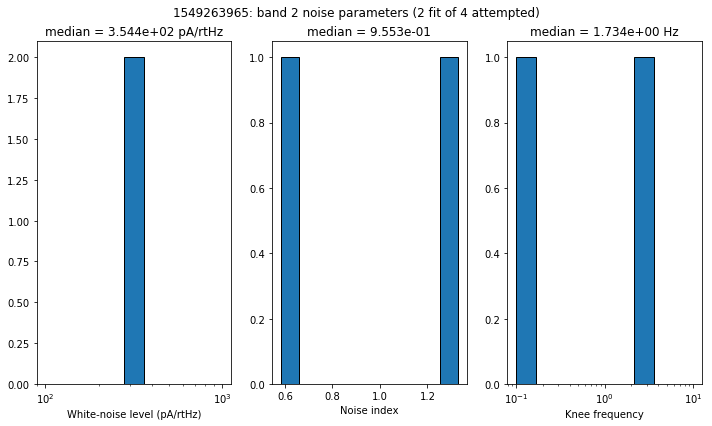

'/data/smurf_data/20190203/1549263430/outputs/1549263965.dat'

In [10]:
S.overbias_tes(3,overbias_voltage=15.,tes_bias=0.75)
S.take_noise_psd(2,30.,channel=[0,16,32,64],detrend='linear')

This function will create several plots in the plot directory and also write data to the outputs directory. The plots show both the timestream and the NEI. The NEI is fit to a noise model that extracts parameters such as the knee frequency, the white-noise level and the negative exponent of the 1/f^n portion.

### Noise vs. bias voltage

We combine our noise-taking functions with TES-biasing functions in a function called noise_vs_bias. This will take a timestream at several bias points, calculate the PSDs (NEI) and overplot them all. The first argument is the band, and the second is a list of groups of just a single group. In Frankenpolar, there is currently only one active bias group, which is group 3. The optional argument "bias" is an array of bias voltages at which to record timestreams. We toggle between high- and low-current mode with the boolean high_current_mode. The voltage used to kick the TESs out of the superconducting state is set with overbias_voltage. The length of the timestream in seconds is set by meas_time. The amount of time to wait for the focal plane to cool before recording data is set by cool_wait, again in seconds. You can include the individual timestreams on the output plots with the boolean make_timestream_plot. If there are many bias points, this will create a rather busy plot. For debugging, though, it can be quite helpful. You can choose which channels to analyze with the optional argument "channel". To avoid wasting time analyzing channels that don't even belong to the bias group, it is often a good idea to actually set this optional argument. You can create a TES catalog from your IV curves.

By setting analyze=True, you are choosing to analyze the timestreams immediately. It is also possible, of course, to analyze them after the fact. It is also possible to incorporate IV information about the TES responsivity to convert NEI to NEP.

In [11]:
S.noise_vs_bias(2,3,bias=[2.,1.,0.75,0.5,0.25,0.],high_current_mode=True,overbias_voltage=15.,meas_time=10.,analyze=True,cool_wait=10.,make_timestream_plot=True,channel=[0,16,32,64])

[ 2019-02-03 23:10:16 ]  Bias 2.0
[ 2019-02-03 23:10:17 ]  Old relay 0b1101
[ 2019-02-03 23:10:17 ]  New relay 0b1101
[ 2019-02-03 23:10:17 ]  Driving high current through TES. Waiting 5.0
[ 2019-02-03 23:10:22 ]  Waiting 10.00 seconds to cool
[ 2019-02-03 23:10:32 ]  Done waiting.
[ 2019-02-03 23:10:32 ]  Taking data
[ 2019-02-03 23:10:32 ]  Starting to take data.
[ 2019-02-03 23:10:33 ]  Writing PyRogue configuration to file : /data/smurf_data/20190203/1549263430/outputs/1549264233.yml
[ 2019-02-03 23:10:43 ]  Writing to file : /data/smurf_data/20190203/1549263430/outputs/1549264233.dat
[ 2019-02-03 23:10:45 ]  Band 2
[ 2019-02-03 23:10:45 ]  Band 3
[ 2019-02-03 23:10:45 ]  Generating gcp mask file. 397 channels added
[ 2019-02-03 23:10:45 ]  Reading SMuRF to GCP config file
[ 2019-02-03 23:10:45 ]  Reading SMuRF to GCP config file
[ 2019-02-03 23:10:46 ]  caput test_epics:AMCc:FpgaTopLevel:AppTop:AppCore:TimingHeader:userConfig[0] 2
[ 2019-02-03 23:10:56 ]  caput test_epics:AMCc:Fpg

/usr/local/controls/package/python/3.6.1/rhel6-x86_64/lib/python3.6/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 8192 is greater than input length  = 1807, using nperseg = 1807
  .format(nperseg, input_length))


[ 2019-02-03 23:14:11 ]  Reading /data/smurf_data/20190203/1549263430/outputs/1549264272.dat


/usr/local/controls/package/python/3.6.1/rhel6-x86_64/lib/python3.6/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 8192 is greater than input length  = 1805, using nperseg = 1805
  .format(nperseg, input_length))


[ 2019-02-03 23:14:12 ]  Reading /data/smurf_data/20190203/1549263430/outputs/1549264311.dat


/usr/local/controls/package/python/3.6.1/rhel6-x86_64/lib/python3.6/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 8192 is greater than input length  = 1806, using nperseg = 1806
  .format(nperseg, input_length))


[ 2019-02-03 23:14:13 ]  Reading /data/smurf_data/20190203/1549263430/outputs/1549264349.dat
[ 2019-02-03 23:14:14 ]  Reading /data/smurf_data/20190203/1549263430/outputs/1549264388.dat
[ 2019-02-03 23:14:15 ]  Reading /data/smurf_data/20190203/1549263430/outputs/1549264427.dat
[ 2019-02-03 23:14:16 ]  /data/smurf_data/20190203/1549263430/outputs/psd/1549264233_psd_ch000.txt
[ 2019-02-03 23:14:16 ]  Smoothing PSDs for plotting with window of length 15
[ 2019-02-03 23:14:16 ]  ch. 0, bias = 2.00, white-noise level = 76.09 pA/rtHz, n = 16.17, f_knee = 0.09 Hz
[ 2019-02-03 23:14:16 ]  /data/smurf_data/20190203/1549263430/outputs/psd/1549264272_psd_ch000.txt
[ 2019-02-03 23:14:16 ]  Smoothing PSDs for plotting with window of length 15
[ 2019-02-03 23:14:16 ]  ch. 0, bias = 1.00, white-noise level = 194.11 pA/rtHz, n = 2.49, f_knee = 0.39 Hz
[ 2019-02-03 23:14:16 ]  /data/smurf_data/20190203/1549263430/outputs/psd/1549264311_psd_ch000.txt
[ 2019-02-03 23:14:16 ]  Smoothing PSDs for plotting

[ 2019-02-03 23:14:31 ]  Saving plot to /data/smurf_data/20190203/1549263430/plots/1549264216_noise_vs_bias_band2_g3_ch064.png
[ 2019-02-03 23:14:33 ]  
Saving NEI histogram to /data/smurf_data/20190203/1549263430/plots/1549264216_noise_vs_bias_band2_g3_NEI_hist.png


Plots are again created in the plots directory. You will see the PSDs overplotted and another figure showing the white-noise level as a function of bias voltage. If you elected to plot the timestream, you will see them below. There is also a histogram summary plot.